# **Installs**

In [1]:
!pip install photutils --quiet
!pip install webbpsf --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.6/915.6 kB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.9/888.9 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.4/961.4 kB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.1/108.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!wget https://stsci.box.com/shared/static/qxpiaxsjwo15ml6m4pkhtk36c9jgj70k.gz -O webbpsf-data-1.2.1.tar.gz

--2023-08-31 20:54:14--  https://stsci.box.com/shared/static/qxpiaxsjwo15ml6m4pkhtk36c9jgj70k.gz
Resolving stsci.box.com (stsci.box.com)... 74.112.186.144
Connecting to stsci.box.com (stsci.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/qxpiaxsjwo15ml6m4pkhtk36c9jgj70k.gz [following]
--2023-08-31 20:54:14--  https://stsci.box.com/public/static/qxpiaxsjwo15ml6m4pkhtk36c9jgj70k.gz
Reusing existing connection to stsci.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://stsci.app.box.com/public/static/qxpiaxsjwo15ml6m4pkhtk36c9jgj70k.gz [following]
--2023-08-31 20:54:14--  https://stsci.app.box.com/public/static/qxpiaxsjwo15ml6m4pkhtk36c9jgj70k.gz
Resolving stsci.app.box.com (stsci.app.box.com)... 74.112.186.144
Connecting to stsci.app.box.com (stsci.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://publ

In [3]:
!tar -xf webbpsf-data-1.2.1.tar.gz

In [4]:
!rm webbpsf-data-1.2.1.tar.gz

In [5]:
!pip uninstall numexpr --quiet -y

# **Imports**

In [6]:
import sys
import time
import numpy as np
import pandas as pd
import glob as glob
import urllib.request
import tarfile
import os

from astropy.io import fits
from astropy.visualization import simple_norm
from astropy.nddata import NDData
from astropy.wcs import WCS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.table import Table, QTable
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
from astropy.stats import SigmaClip, sigma_clipped_stats, gaussian_fwhm_to_sigma
from astropy.convolution import Gaussian2DKernel, convolve_fft

from photutils.background import MMMBackground, MADStdBackgroundRMS, Background2D, LocalBackground
from photutils.detection import DAOStarFinder
from photutils.psf import EPSFBuilder, GriddedPSFModel
from photutils.psf import SourceGrouper, extract_stars, IterativePSFPhotometry

from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry

In [7]:
os.environ['WEBBPSF_PATH'] = '/content/webbpsf-data'

In [8]:
%matplotlib inline
from matplotlib import style, pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.colors as col

from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (12,12)
plt.rcParams['axes.titlesize'] = plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 15

font1 = {'family': 'sans-serif', 'color': 'black', 'weight': 'normal', 'size': '12'}
font2 = {'family': 'sans-serif', 'color': 'black', 'weight': 'normal', 'size': '20'}

In [9]:
import webbpsf
from webbpsf.utils import to_griddedpsfmodel

In [10]:
filters = ['F070W', 'F090W', 'F115W', 'F140M', 'F150W2', 'F150W', 'F162M', 'F164N', 'F182M',
           'F187N', 'F200W', 'F210M', 'F212N', 'F250M', 'F277W', 'F300M', 'F322W2', 'F323N',
           'F335M', 'F356W', 'F360M', 'F405N', 'F410M', 'F430M', 'F444W', 'F460M', 'F466N', 'F470N', 'F480M']

psf_fwhm = [0.987, 1.103, 1.298, 1.553, 1.628, 1.770, 1.801, 1.494, 1.990, 2.060, 2.141, 2.304, 2.341, 1.340,
            1.444, 1.585, 1.547, 1.711, 1.760, 1.830, 1.901, 2.165, 2.179, 2.300, 2.302, 2.459, 2.507, 2.535, 2.574]

dict_utils = {filters[i]: {'psf fwhm': psf_fwhm[i]} for i in range(len(filters))}

# **Synthetic PSF using Webb PSF**

In [11]:
def create_psf_model(det='NRCA1', filt='F070W', fov=101, source=None,
                     create_grid=False, num=9, save_psf=False,
                     detsampled=False):

    nrc = webbpsf.NIRCam()

    nrc.detector = det
    nrc.filter = filt

    print("Using a {field}".format(field=fov), "px fov")

    if create_grid:
        print("")
        print("Creating a grid of PSF for filter {filt} and detector {det}".format(filt=filt, det=det))
        print("")
        num = num

        if save_psf:

            outname = 'PSF_%s_samp4_fov%d_npsfs%d.fits' % (filt, fov, num)
            psf = nrc.psf_grid(num_psfs=num, oversample=4, source=source, all_detectors=False, fov_pixels=fov,
                               save=True, outfile=os.path.join(psfs_dir,outname), use_detsampled_psf=detsampled)

        else:

            psf = nrc.psf_grid(num_psfs=num, oversample=4, source=source, all_detectors=False, fov_pixels=fov,
                               use_detsampled_psf=detsampled)

    else:
        print("")
        print("Creating a single PSF for filter {filt} and detector {det}".format(filt=filt, det=det))
        print("")
        num = 1

        if save_psf:

            outname = 'PSF_%s_samp4_fov%d_npsfs%d.fits' % (filt, fov, num)
            psf = nrc.psf_grid(num_psfs=num, oversample=4, source=source, all_detectors=False, fov_pixels=fov,
                               save=True, outfile=os.path.join(psfs_dir,outname), use_detsampled_psf=detsampled)

        else:

            psf = nrc.psf_grid(num_psfs=num, oversample=4, source=source, all_detectors=False, fov_pixels=fov,
                               use_detsampled_psf=detsampled)

    return psf

# **Empirical PSF**

In this section we explore how to construct an empirical PSF from the data using Astropy and Photutils

## **Source Detection**

As a first step to empirical PSF construction we select the stars using which we will be constructing the PSF. We use Photutils Backgound2D for estimating the background and create background subtracted image for employing DAOStarFinder for detecting sources.

In [12]:
def calc_bkg(data, sigma=3.0):

    bkgrms = MADStdBackgroundRMS()
    mmm_bkg = MMMBackground()

    sigma_clip = SigmaClip(sigma=sigma)
    coverage_mask = (data == 0)

    bkg = Background2D(data, (100, 100), filter_size=(3, 3),
                       sigma_clip=sigma_clip, bkg_estimator=mmm_bkg,
                        coverage_mask=coverage_mask, fill_value=0.0)

    data_bkgsub = data.copy()
    data_bkgsub = data_bkgsub - bkg.background

    _, _, std = sigma_clipped_stats(data_bkgsub)

    return data_bkgsub, std

In [13]:
def find_stars(data, det='NRCA1', filt='F070W', threshold=3, sigma=3.0, sigma_psf=None, smoothen=True, kernel=None):

    if sigma_psf is None:
        sigma_psf = dict_utils[filt]['psf fwhm']

    data, std = calc_bkg(data, sigma)

    if smoothen and kernel is not None:
        data = convolve_fft(data, kernel)

    daofind = DAOStarFinder(threshold=threshold*std, fwhm=sigma_psf)
    found_stars = daofind(data)

    print('\nNumber of sources found in the image:', len(found_stars))
    print('-------------------------------------\n')

    return found_stars, data

## **Source Selection**

In this section we select the sources for empirical PSF construction. We want sources which are sufficiently round, sharp and bright. Thus, we apply roundness, sharpness and magnitude cuts based on thier distribuitions.

In [14]:
def select_stars(found_stars, mag_lim, round_inf=-0.4, round_sup=0.4, sh_inf=0.78, sh_sup=0.92, min_sep=10):

    mask = ((found_stars['mag'] < mag_lim) & (found_stars['roundness2'] > round_inf)
            & (found_stars['roundness2'] < round_sup) & (found_stars['sharpness'] > sh_inf)
            & (found_stars['sharpness'] < sh_sup))

    found_stars_sel = found_stars[mask]
    found_stars_sel_f115w = found_stars_sel

    print('Number of stars selected to build ePSF:', len(found_stars_sel))

    # if we include the separation criteria:

    d = []

    x_tot = found_stars['xcentroid']
    y_tot = found_stars['ycentroid']

    for xx, yy in zip(found_stars_sel['xcentroid'], found_stars_sel['ycentroid']):

        sep = []
        dist = np.sqrt((x_tot - xx)**2 + (y_tot - yy)**2)
        sep = np.sort(dist)[1:2][0]
        d.append(sep)

    found_stars_sel['min distance'] = d
    mask_dist = (found_stars_sel['min distance'] > min_sep)

    found_stars_sel2 = found_stars_sel[mask_dist]

    print('Number of stars selected to build ePSF \
    \nincluding "mimimum distance closest neighbour" selection):', len(found_stars_sel2))

    return found_stars_sel2

In [15]:
def build_epsf(data, det='NRCA1', filt='F070W', size=11, found_table=None, oversample=4, iters=10):

    hsize = (size - 1) / 2

    x = found_table['xcentroid']
    y = found_table['ycentroid']

    mask = ((x > hsize) & (x < (data.shape[1] - 1 - hsize)) & (y > hsize) & (y < (data.shape[0] - 1 - hsize)))

    stars_tbl = Table()
    stars_tbl['x'] = x[mask]
    stars_tbl['y'] = y[mask]

    data_bkgsub, _ = calc_bkg(data)

    nddata = NDData(data=data)
    stars = extract_stars(nddata, stars_tbl, size=size)

    print('Creating ePSF --- Detector {d}, filter {f}'.format(f=filt, d=det))

    epsf_builder = EPSFBuilder(oversampling=oversample, maxiters=iters, progress_bar=True)

    epsf, fitted_stars = epsf_builder(stars)

    return epsf

# **PSF Photometry using Photutils**

In [16]:
def psf_phot(data=None, det='NRCA1', filt='F070W', th=2000,
             fit_shape=(11,11),
             psf=None, ap_radius=3.5, save_residuals=False,
             save_output=False,
             maxiters=2):

    fitter = LevMarLSQFitter()
    bkgstat = MMMBackground()
    localbkg_estimator = LocalBackground(11, 16, bkgstat)

    sigma_psf = dict_utils[filt]['psf fwhm']
    print('FWHM for filter {f}:'.format(f=filt), sigma_psf)

    _, std = calc_bkg(data)

    daofind = DAOStarFinder(threshold=th*std, fwhm=sigma_psf)

    grouper = SourceGrouper(5.0*sigma_psf)

    psf_model = psf.copy()

    print('Performing the PSF photometry --- Detector {d}, filter {f}'.format(f=filt, d=det))

    tic = time.perf_counter()

    phot = IterativePSFPhotometry(finder=daofind, grouper=grouper,
                                  localbkg_estimator=localbkg_estimator,
                                  psf_model=psf_model,fitter=fitter,
                                  maxiters=maxiters, fit_shape=fit_shape,
                                  aperture_radius=ap_radius,
                                  progress_bar = True)
    result = phot(data)

    toc = time.perf_counter()

    print('Time needed to perform photometry:', '%.2f' % ((toc - tic) / 3600), 'hours')
    print('Number of sources detected:', len(result))

    residual_image = phot.make_residual_image(data,(11,11))

    # save the residual images as fits file:

    if save_residuals:
        hdu = fits.PrimaryHDU(residual_image)
        hdul = fits.HDUList([hdu])

        residual_outname = 'residual_%s_%s.fits' % (det, filt)

        hdul.writeto(os.path.join(res_dir, residual_outname))

    # save the output photometry Tables

    if save_output:

        outname = 'phot_%s_%s.pkl' % (det, filt)

        tab = result.to_pandas()
        tab.to_pickle(os.path.join(output_phot_dir, outname))

    return result, residual_image, phot

# **Pipeline**

## **Input Data**

In [17]:
dict_images = {'NRCA1': {}, 'NRCA2': {}, 'NRCA3': {}, 'NRCA4': {}, 'NRCA5': {},
               'NRCB1': {}, 'NRCB2': {}, 'NRCB3': {}, 'NRCB4': {}, 'NRCB5': {}}

dict_filter_short = {}
dict_filter_long = {}

ff_short = []
det_short = []
det_long = []
ff_long = []
detlist_short = []
detlist_long = []
filtlist_short = []
filtlist_long = []

data_dir = '.'

if not glob.glob(f'{data_dir}/*cal*fits'):

    print("Downloading images")

    boxlink_images_lev2 = 'https://stsci.box.com/shared/static/dt0gm0lyvi1yfh942vad6a8gb5utd85m.gz'
    boxfile_images_lev2 = './single_images_lev2.tar.gz'
    urllib.request.urlretrieve(boxlink_images_lev2, boxfile_images_lev2)

    tar = tarfile.open(boxfile_images_lev2, 'r')
    tar.extractall()

    images_dir = f'{data_dir}/'
    images = sorted(glob.glob(os.path.join(images_dir, "*cal.fits")))

else:

    images_dir = f'{data_dir}'
    images = sorted(glob.glob(os.path.join(images_dir, "*cal.fits")))

for image in images:

    im = fits.open(image)
    f = im[0].header['FILTER']
    d = im[0].header['DETECTOR']

    if d == 'NRCBLONG':
        d = 'NRCB5'
    elif d == 'NRCALONG':
        d = 'NRCA5'
    else:
        d = d

    wv = float(f[1:3])

    if wv > 24:
        ff_long.append(f)
        det_long.append(d)

    else:
        ff_short.append(f)
        det_short.append(d)

    detlist_short = sorted(list(dict.fromkeys(det_short)))
    detlist_long = sorted(list(dict.fromkeys(det_long)))

    unique_list_filters_short = []
    unique_list_filters_long = []

    for x in ff_short:

        if x not in unique_list_filters_short:

            dict_filter_short.setdefault(x, {})

    for x in ff_long:
        if x not in unique_list_filters_long:
            dict_filter_long.setdefault(x, {})

    for d_s in detlist_short:
        dict_images[d_s] = dict_filter_short

    for d_l in detlist_long:
        dict_images[d_l] = dict_filter_long

    filtlist_short = sorted(list(dict.fromkeys(dict_filter_short)))
    filtlist_long = sorted(list(dict.fromkeys(dict_filter_long)))

    if len(dict_images[d][f]) == 0:
        dict_images[d][f] = {'images': [image]}
    else:
        dict_images[d][f]['images'].append(image)

print("Available Detectors for SW channel:", detlist_short)
print("Available Detectors for LW channel:", detlist_long)
print("Available SW Filters:", filtlist_short)
print("Available LW Filters:", filtlist_long)

Available Detectors for SW channel: ['NRCB1']
Available Detectors for LW channel: ['NRCB5']
Available SW Filters: ['F115W', 'F200W']
Available LW Filters: ['F277W', 'F444W']


In [18]:
det = 'NRCB1'
filt = 'F115W'

hdul = fits.open(dict_images[det][filt]['images'][0])
data_sb = hdul[1].data

imh = hdul[1].header
wcs = WCS(hdul[1].header)
data = data_sb / imh['PHOTMJSR']
print('Conversion factor from {units} to DN/s for filter {f}:'.format(units=imh['BUNIT'], f=filt), imh['PHOTMJSR'])
area = hdul[4].data
data = data * area

Conversion factor from MJy/sr to DN/s for filter F115W: 3.821892261505127


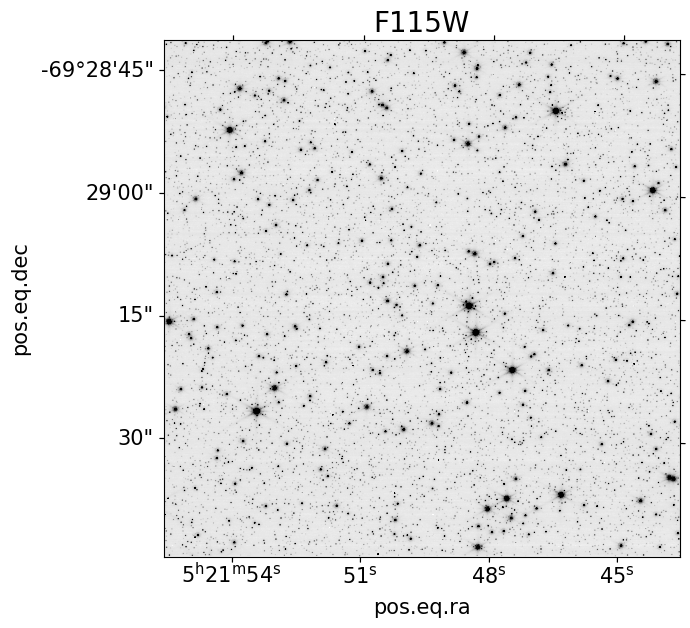

In [19]:
plt.figure(figsize=(7, 7))

ax = plt.subplot(1, 1, 1, projection=wcs)

plt.title(filt, fontdict=font2)
norm = simple_norm(data, 'sqrt', percent=99.)

ax.imshow(data, norm=norm, cmap='Greys')

plt.tight_layout()

## **PSF**

### **Synthetic PSF**

In [ ]:
psfs_dir = 'PSF_MODELS/'

if not os.path.exists(psfs_dir):
    os.makedirs(psfs_dir)

psf_webbpsf_single = create_psf_model(det=det, filt=filt, fov=51, source=None, create_grid=False, save_psf=False,
                                      detsampled=False)

In [20]:
psfs_dir = 'PSF_MODELS/'

if not os.path.exists(psfs_dir):
    os.makedirs(psfs_dir)

psf_webbpsf_grid = create_psf_model(det=det, filt=filt, fov=51, source=None, create_grid=True, num=16,
                                    save_psf=False, detsampled=False)

Using a 51 px fov

Creating a grid of PSF for filter F115W and detector NRCB1


Running instrument: NIRCam, filter: F115W
  Running detector: NRCB1
    Position 1/16: (0, 0) pixels
    Position 1/16 centroid: (101.4139433170375, 101.27816268514347)
    Position 2/16: (0, 682) pixels
    Position 2/16 centroid: (101.53087472922604, 101.16665316242036)
    Position 3/16: (0, 1365) pixels
    Position 3/16 centroid: (101.6668682608167, 101.1513225859101)
    Position 4/16: (0, 2047) pixels
    Position 4/16 centroid: (101.80308521238825, 101.23672463922765)
    Position 5/16: (682, 0) pixels
    Position 5/16 centroid: (101.4061658308943, 101.29226414261228)
    Position 6/16: (682, 682) pixels
    Position 6/16 centroid: (101.54980655247849, 101.33073137794545)
    Position 7/16: (682, 1365) pixels
    Position 7/16 centroid: (101.70572497597668, 101.30816686559425)
    Position 8/16: (682, 2047) pixels
    Position 8/16 centroid: (101.84268189868885, 101.30682665606176)
    Position 9/1

### **Empirical PSF**

In [ ]:
tic = time.perf_counter()

# Source Detection

found_stars, data_out = find_stars(data, det=det, filt=filt, threshold=10, smoothen=False)

toc = time.perf_counter()

print("Elapsed Time for finding stars:", toc - tic)

In [ ]:
# Source Selection
plt.figure(figsize=(12, 8))
plt.clf()

ax1 = plt.subplot(2, 1, 1)

ax1.set_xlabel('mag', fontdict=font2)
ax1.set_ylabel('sharpness', fontdict=font2)

xlim0 = np.min(found_stars['mag']) - 0.25
xlim1 = np.max(found_stars['mag']) + 0.25
ylim0 = np.min(found_stars['sharpness']) - 0.15
ylim1 = np.max(found_stars['sharpness']) + 0.15

ax1.set_xlim(xlim0, xlim1)
ax1.set_ylim(ylim0, ylim1)

ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.scatter(found_stars['mag'], found_stars['sharpness'], s=10, color='k')

sh_inf = 0.78
sh_sup = 0.92
mag_lim = -4.0

ax1.plot([xlim0, xlim1], [sh_sup, sh_sup], color='r', lw=3, ls='--')
ax1.plot([xlim0, xlim1], [sh_inf, sh_inf], color='r', lw=3, ls='--')
ax1.plot([mag_lim, mag_lim], [ylim0, ylim1], color='r', lw=3, ls='--')

ax2 = plt.subplot(2, 1, 2)

ax2.set_xlabel('mag', fontdict=font2)
ax2.set_ylabel('roundness', fontdict=font2)

ylim0 = np.min(found_stars['roundness2']) - 0.25
ylim1 = np.max(found_stars['roundness2']) - 0.25

ax2.set_xlim(xlim0, xlim1)
ax2.set_ylim(ylim0, ylim1)

ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(ticker.AutoLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

round_inf = -0.40
round_sup = 0.40

ax2.scatter(found_stars['mag'], found_stars['roundness2'], s=10, color='k')

ax2.plot([xlim0, xlim1], [round_sup, round_sup], color='r', lw=3, ls='--')
ax2.plot([xlim0, xlim1], [round_inf, round_inf], color='r', lw=3, ls='--')
ax2.plot([mag_lim, mag_lim], [ylim0, ylim1], color='r', lw=3, ls='--')

plt.tight_layout()

In [ ]:
found_table_sel = select_stars(found_stars, mag_lim, round_inf, round_sup, sh_inf, sh_sup, min_sep=20)

In [ ]:
# Building Empirical PSF
epsf = build_epsf(data, det=det, filt=filt, size=21, found_table=found_table_sel, oversample=4, iters=10)

In [ ]:
plt.imshow(epsf.data, norm=col.LogNorm())

## **Photometry**

In [ ]:
data1 = data
# data1 = data

output_phot_dir = 'PHOT_OUTPUT/'

if not os.path.exists(output_phot_dir):
    os.makedirs(output_phot_dir)

res_dir = 'RESIDUAL_IMAGES/'

if not os.path.exists(res_dir):
    os.makedirs(res_dir)

if glob.glob(os.path.join(res_dir, 'residual*F115W.fits')):
    print('Deleting Residual images from directory')
    files = glob.glob(os.path.join(res_dir, 'residual*F115W.fits'))
    for file in files:
        os.remove(file)

psf_phot_table, residual_image, phot = psf_phot(data=data1, det=det, filt=filt, th=10, psf=epsf,
                                            save_residuals=True, save_output=True, maxiters=3)

In [ ]:
psf_phot_results = psf_phot_results[(psf_phot_results['flux_fit']>0) & (psf_phot_results['flags']!=8)]

In [ ]:
help(phot)

In [ ]:
psf_phot_results

In [ ]:
plt.imshow(residual_image, norm= col.LogNorm())

In [ ]:
positions = np.transpose([psf_phot_results['x_fit'].value, psf_phot_results['y_fit'].value])

In [ ]:
coords = np.array(wcs.pixel_to_world_values(positions))
psf_phot_results['ra'] = coords[:,0]
psf_phot_results['dec'] = coords[:,1]

In [ ]:
psf_phot_results

In [ ]:
apers = CircularAperture(positions, r = 6.5)
bag_apers = CircularAnnulus(positions, 8,11)
phot_table = aperture_photometry(data1, [apers, bag_apers])

In [ ]:
phot_table['sky_flux'] = phot_table['aperture_sum_1']*(apers.area/bag_apers.area)

# calculate source flux
phot_table['flux'] = phot_table['aperture_sum_0'].value #- phot_table['sky_flux'].value
# calculate error on the source flux
phot_table['flux_err'] = np.sqrt(phot_table['flux'].value + phot_table['sky_flux'].value)

# calculate signal to noise ratio
phot_table['SNR'] = phot_table['flux']/phot_table['flux_err']

In [ ]:
phot_table

In [ ]:
x = phot_table['flux']
y = psf_phot_results['flux_fit']
plt.scatter(x,y, color = 'black',s=1)

In [ ]:
positions = np.transpose([phot_table['xcenter'].value, phot_table['ycenter'].value])

In [ ]:
coords = np.array(wcs.pixel_to_world_values(positions))
phot_table['ra'] = coords[:,0]
phot_table['dec'] = coords[:,1]

In [ ]:
pos1 = SkyCoord(psf_phot_results['ra'], psf_phot_results['dec'], unit='deg')
pos2 = SkyCoord(phot_table['ra'], phot_table['dec'], unit='deg')

In [ ]:
plt.figure(figsize=(16, 14))

ax1 = plt.subplot(2, 2, 1)

plt.xlabel("X [px]", fontdict=font2)
plt.ylabel("Y [px]", fontdict=font2)
plt.title(filt, fontdict=font2)

norm = simple_norm(data1, 'sqrt', percent=99.)
ax1.imshow(data1, norm=norm, cmap='Greys')

ax2 = plt.subplot(2, 2, 2)

plt.xlabel("X [px]", fontdict=font2)
plt.ylabel("Y [px]", fontdict=font2)
plt.title('residuals', fontdict=font2)

norm = simple_norm(data1, 'sqrt', percent=99.)
ax2.imshow(residual_image, norm=norm, cmap='Greys')

apertures.plot(ax1, color = 'red', lw=2);